In [2]:
import os 
from datetime import timedelta

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

DATA_DIR = '/pool001/jschless/kiran-data/kiran-data/'
TURKEY_DIR = '/pool001/jschless/turkish_astroturfing'

In [3]:
# Loading df created in the Turkey_Data_Wrangling notebook
df = pd.read_pickle(os.path.join(DATA_DIR, 'mega_df_full_follower_top_60.pkl'))

In [4]:
# get all users that posted a lexicon tweet
astrobots = set(df.query('lexicon == True').author_id.unique())

In [5]:
len(df.trend.unique())

418

In [27]:
len(df)

17829530

## Transforming Raw Data into A Panel of Time Series

In [7]:
def build_df(df, trend,
             include_missing=False, 
             drop_astrobots=True,
             time_bin='5Min', 
             minutes_to_round=5):
    # takes the dataframe and a hashtag and converts it to a event study dataframe for that hashtag

    df = df[df.trend == trend].set_index('created_at')
        
    if not include_missing: 
        # Remove tweets from users lacking follower info
        # df = df.query('author_id != -1 and author != "missing"')
        df = df[df.follower_data == True]

    if drop_astrobots:
        # Remove tweets from users that posted lexicon tweets
        df = df[~df.author_id.isin(astrobots)]

    try:
        start, end = df.iloc[0].tr_start, df.iloc[0].tr_end
    except Exception as e:
        print('issue with trending data for ', trend)
        return None
    start = start - timedelta(minutes=start.minute % minutes_to_round,
                              seconds=start.second,
                              microseconds=start.microsecond)

    df['tweet_type'] = df.text.apply(lambda x: 'retweet' if x.startswith('RT') else 'tweet')
    
    # Binning various statistics of interest
    series_list = []
    
    
    types = ['tweet', 'retweet']    
    # bin tweets and retweets separately
    for t in types:
        series_list.append(
            df[df.tweet_type == t]
              .resample(time_bin)
              .count()
              .author_id
        )
        
    # add in the tweets from unexposed users
    series_list.append(
        df.query('tweet_type == "tweet" and exposed == False')
          .resample(time_bin)
          .count()
          .author_id
    )
        
    new_df = pd.DataFrame(series_list).T
    new_df.columns = [*types, 'zero_exposure_tweets']
    
    # normalize time to minutes before / after trend
    new_df['absolute_time'] = new_df.index
    new_df.index = new_df.index - start
    new_df.index = new_df.index.map(lambda x: int(x.total_seconds() / 60))

    # add additional info to dataset
    new_df['trend'] = trend
    new_df['time'] = new_df.index
    new_df['time_i'] = range(len(new_df))
    new_df['trending_start'] = start

    return new_df

### Selecting Specific Hashtags
There are a lot of hashtags, so it might be worthwhile to remove the hashtags at either extreme. 

In [9]:
sizes = df.groupby('trend').size()
lower, upper = 0, 1 # thresholds for which quantiles to include
l, u = sizes.quantile([lower, upper])

# only select trends between the lower and upper thresholds
trends = sizes.where(sizes <= u).where(sizes >= l).dropna().index 

In [8]:
sizes.describe()

NameError: name 'sizes' is not defined

## Building Panel
For each selected trend, build the panel

In [10]:
dfs = []
for trend in tqdm(trends):
    temp_df = build_df(df, trend, time_bin='5Min', minutes_to_round=5)

    if not temp_df is None:
        # assign dummy variable for whether a hashtag is trending or not
        temp_df = temp_df.assign(threshold=(temp_df.time > 0).astype(int))
        dfs.append(temp_df)
panel_df = pd.concat(dfs)

 69%|██████▉   | 288/418 [28:08<03:53,  1.80s/it]  

issue with trending data for  #TebriklerHamsiBaklava


100%|██████████| 418/418 [43:08<00:00,  6.19s/it]


In [30]:
panel_df.zero_exposure_tweets.sum()

917166.0

In [11]:
panel_df.to_pickle(os.path.join(DATA_DIR, 'full_panel_all_followers_top_50.pkl'))

In [22]:
# load full panel from memory
panel_df = pd.read_pickle(os.path.join(DATA_DIR, 'full_panel_all_followers_top_50.pkl'))

In [35]:
ls '/pool001/jschless/kiran-data/kiran-data/'

campaigns.pkl                        hashtag_mapping.txt*
FRIENDS1.txt                         mega_df_full_follower.pkl
friends_dict.pkl                     mega_df_full_follower_top_60.pkl
FRIENDS.txt*                         mega_df.pkl
full_panel_all_followers.pkl         README.txt*
full_panel_all_followers_top_50.pkl  turkish_data_for_joe.zip
full_panel_df.pkl                    TWEETINFO.txt*
hashtag_data/


In [22]:
# load full panel from memory
panel_df = pd.read_pickle(os.path.join(DATA_DIR, 'full_panel_all_followers_top_50.pkl'))

In [36]:
pd.read_pickle(os.path.join(DATA_DIR, 'full_panel_all_followers.pkl')).zero_exposure_tweets.sum()

420370.0

In [1]:
DATA_DIR

NameError: name 'DATA_DIR' is not defined

In [23]:
def plot_event_study(df, cat: str='zero_exposure_tweets', quantiles=(.025,.975),
                    lower=-120, upper=120, title=None):
    # useful for plotting panel data
    if title is None:
        title = cat
    df = df.loc[(df.index>lower)&(df.index<upper)]
    median = df.groupby('time')[cat].median()
    mean = df.groupby('time')[cat].mean()
    p025 = df.groupby('time')[cat].quantile(quantiles[0])
    p975 = df.groupby('time')[cat].quantile(quantiles[1])
    plt.errorbar(mean.index, mean, xerr=.5, yerr=[mean-p025, p975-mean],
                 fmt='o', capsize=10, label='mean')
    plt.scatter(median.index, median, c='r', label='median')
    print(df.describe())
    plt.title('Event Study of ' + title)
    plt.xlabel('Time Since Trending')
    plt.ylabel('Count')
    plt.legend()

              tweet      retweet  zero_exposure_tweets          time  \
count  13529.000000  5242.000000          13478.000000  13536.000000   
mean      36.953951     6.070011             11.657739     24.731826   
std       96.537126    18.807825             26.590302     62.321827   
min        0.000000     0.000000              0.000000   -115.000000   
25%        0.000000     0.000000              0.000000    -15.000000   
50%        6.000000     0.000000              2.000000     35.000000   
75%       33.000000     4.000000             12.000000     75.000000   
max     1490.000000   288.000000            485.000000    115.000000   

             time_i     threshold  
count  1.353600e+04  13536.000000  
mean   1.447044e+05      0.682255  
std    2.650280e+05      0.465617  
min    0.000000e+00      0.000000  
25%    1.300000e+01      0.000000  
50%    5.200000e+01      1.000000  
75%    1.680530e+05      1.000000  
max    1.001213e+06      1.000000  


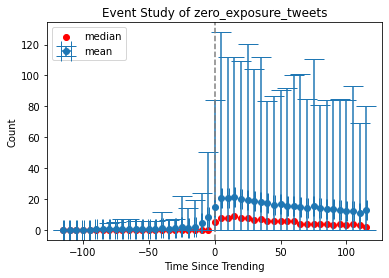

In [24]:
plot_event_study(panel_df)
plt.axvline(c='grey', ls='--')

## Statistical Analysis

In [41]:
query.zero_exposure_tweets.sum()

97196.0

In [25]:
from statsmodels.formula.api import poisson
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.formula.api import negativebinomial

query = panel_df.query('time >= -60 & time <= 60').fillna(0)
query.trend = pd.Categorical(query.trend).codes
query = query.dropna()

formula_string = "tweet ~ time*threshold"

query['ln_tweet'] = np.log(query.tweet + 1)

ols = smf.ols(formula_string, data=query).fit(
    cov_type='cluster', cov_kwds={'groups': query['trend']})


re = smf.mixedlm(formula_string, data=query, groups=query['trend']).fit()
re_ln = smf.mixedlm('ln_' + formula_string, data=query, groups=query['trend']).fit()

#formula_string += "+ C(trend)"
pois = poisson(formula_string, data=query).fit()
negbin = negativebinomial(formula_string, data=query).fit()

Optimization terminated successfully.
         Current function value: 44.848873
         Iterations 7
Optimization terminated successfully.
         Current function value: 3.954899
         Iterations: 25
         Function evaluations: 29
         Gradient evaluations: 29


/home/jschless/.conda/envs/gt/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2566: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/jschless/.conda/envs/gt/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2566: RuntimeWarning: invalid value encountered in multiply
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)


In [26]:
from statsmodels.iolib.summary2 import summary_col
summary_col([re_ln, pois, negbin], 
           model_names=['Random Effects (logged outcome)', 'Poisson', 'Negative Binomial'],
           regressor_order=['time', 'threshold', 'time:threshold', 'Intercept'],
            drop_omitted=True)

,Random Effects (logged outcome),Poisson,Negative Binomial
time,0.0279,0.0550,0.0435
,(0.0010),(0.0004),(0.0017)
threshold,1.3245,0.5403,0.7461
,(0.0446),(0.0081),(0.0828)
time:threshold,-0.0330,-0.0577,-0.0463
,(0.0013),(0.0004),(0.0024)
Intercept,1.6562,3.5663,3.3640
,(0.0749),(0.0070),(0.0581)


In [64]:
np.exp(.6)

1.8221188003905089

## Who is tweeting before the hashtag trends?

In [17]:
len(df.drop_duplicates(subset=['id']).query('exposed == False and follower_data == True'))

244069

In [18]:
before_trend = (df.drop_duplicates(subset=['id'])
                .query('exposed == False and follower_data == True')
                .query('time_since_trending < -5 and time_since_trending > -30')
               )
before_trend

,created_at,id,text,author,author_id,trend,exposed,date,trend_date,tweet_type,tr_start,tr_end,vol,max_rank,lifetime,attack,time_trending,time_since_trending,lexicon,follower_data
10974,2019-07-05 16:31:23,1147181188408401920,@ekrem_imamoglu Başkanım mühendisler atama bek...,haritahane,1073513528647127040,#ReisMühendisMimarAta,False,NaT,NaT,NaN,2019-07-05 16:37:48,2019-07-05 18:07:49,-1,3,0 days 01:30:01.000000000,True,01:30:01,-6,False,True
10994,2019-07-05 16:29:28,1147180704171810816,Kamuya 8bin bekçiyi rahatça alırken\n\nMühendi...,bseyldrkk,417426960,#ReisMühendisMimarAta,False,NaT,NaT,NaN,2019-07-05 16:37:48,2019-07-05 18:07:49,-1,3,0 days 01:30:01.000000000,True,01:30:01,-8,False,True
10996,2019-07-05 16:29:16,1147180654922260480,İnşaat mühendislerine 12 ayda sadece 47 kadro ...,bseyldrkk,417426960,#ReisMühendisMimarAta,False,NaT,NaT,NaN,2019-07-05 16:37:48,2019-07-05 18:07:49,-1,3,0 days 01:30:01.000000000,True,01:30:01,-8,False,True
10998,2019-07-05 16:29:04,1147180605727236096,Mülakatsız atama istiyoruz #ReisMühendisMimarA...,bseyldrkk,417426960,#ReisMühendisMimarAta,False,NaT,NaT,NaN,2019-07-05 16:37:48,2019-07-05 18:07:49,-1,3,0 days 01:30:01.000000000,True,01:30:01,-8,False,True
11005,2019-07-05 16:28:37,1147180493538037761,Özel sektörde iş yok devlette yok. \nBiz ne ya...,bseyldrkk,417426960,#ReisMühendisMimarAta,False,NaT,NaT,NaN,2019-07-05 16:37:48,2019-07-05 18:07:49,-1,3,0 days 01:30:01.000000000,True,01:30:01,-9,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7988173,2019-06-18 18:05:21,1141044240333639686,#HamzaHocaKomisyonuBitr yüzümüw gülsün,Faruk05377377,1131554702322216960,#HamzaHocaKomisyonuBitr,False,NaT,NaT,NaN,2019-06-18 18:13:27,2019-06-18 19:19:50,-1,1,0 days 01:06:23.000000000,True,01:06:23,-8,False,True
7988174,2019-06-18 18:03:24,1141043750350835713,Müdürüm imzalar atılsın komisyon kurulsun #Ham...,Ramazan55932051,1003742209890496518,#HamzaHocaKomisyonuBitr,False,NaT,NaT,NaN,2019-06-18 18:13:27,2019-06-18 19:19:50,-1,1,0 days 01:06:23.000000000,True,01:06:23,-10,False,True
7988175,2019-06-18 18:03:24,1141043749868449793,#HamzaHocaKomisyonuBitr\n1 İmza = 1 Hayat,Bubi81578575,1132777442916130817,#HamzaHocaKomisyonuBitr,False,NaT,NaT,NaN,2019-06-18 18:13:27,2019-06-18 19:19:50,-1,1,0 days 01:06:23.000000000,True,01:06:23,-10,False,True
7988176,2019-06-18 18:02:56,1141043632721584131,Müdürüm komisyon kurulsun çok bekledik #Hamza...,Ramazan55932051,1003742209890496518,#HamzaHocaKomisyonuBitr,False,NaT,NaT,NaN,2019-06-18 18:13:27,2019-06-18 19:19:50,-1,1,0 days 01:06:23.000000000,True,01:06:23,-10,False,True


In [19]:
query.zero_exposure_tweets.sum()

46000.0

In [38]:
df['tweet_type'] = df.text.apply(lambda x: 'retweet' if x.startswith('RT') else 'tweet')
trimming_df = df
print('df starting size', len(trimming_df))
trimming_df = trimming_df.drop_duplicates(subset=['id'])
print('df after removing duplicated tweet ids', len(trimming_df))

trimming_df = trimming_df.query('tweet_type == "tweet"')
print('df after removing retweets', len(trimming_df))

trimming_df = trimming_df.query('follower_data == True')
print('df after removing tweets from users without following data', len(trimming_df))

astrobots = set(df.query('lexicon == True').author_id.unique())
trimming_df = trimming_df[~trimming_df.author_id.isin(astrobots)]
print('df after removing astrobot tweets', len(trimming_df))

trimming_df = trimming_df.query('exposed == False')
print('df after removing exposed tweets', len(trimming_df))

# trimming_df = trimming_df.query('time_since_trending <= 60 and time_since_trending >= -60')
# print('df after removing tweets from outside the hour before and after', len(trimming_df))


df starting size 17829530
df after removing duplicated tweet ids 3051252
df after removing retweets 2997521
df after removing tweets from users without following data 2422731
df after removing astrobot tweets 2052588
df after removing exposed tweets 205439


In [111]:
trimming_df.describe()

,id,author_id,vol,max_rank,time_since_trending
count,1.461000e+04,1.461000e+04,14610.000000,14610.000000,1.461000e+04
mean,1.075116e+18,6.130679e+17,11180.313621,1.449624,-2.727689e+05
std,1.890861e+17,4.968351e+17,37362.347783,0.917182,7.559540e+05
min,1.082295e+10,9.135112e+06,-1.000000,1.000000,-4.883148e+06
25%,9.841624e+17,2.675648e+09,-1.000000,1.000000,-6.241628e+05
50%,1.130085e+18,8.229652e+17,-1.000000,1.000000,-5.765200e+04
75%,1.149419e+18,1.049335e+18,-1.000000,1.000000,1.563500e+03
max,1.408818e+18,1.376274e+18,414069.000000,7.000000,1.060808e+06


In [108]:
trimming_df

,created_at,id,text,author,author_id,trend,exposed,date,trend_date,tweet_type,tr_start,tr_end,vol,max_rank,lifetime,attack,time_since_trending,lexicon,follower_data
0,2020-05-02 14:05:16,1256585550796148738,#MilliGazeteOkuyorum #SesimizBir #Cumartesi #D...,GunesliGuzel,293656352,#ÜniversiteliİşçilereAdalet,False,NaT,NaT,tweet,2019-07-05 17:32:49,2019-07-05 18:12:53,-1,1,0 days 00:40:04.000000000,True,434672,False,True
84,2019-10-29 23:51:31,1189328944518049798,#AtatürkünSevdiğiYemekler En çokta zeytinyağlı...,alialemdaroglu_,872503566090547201,#ÜniversiteliİşçilereAdalet,False,NaT,NaT,tweet,2019-07-05 17:32:49,2019-07-05 18:12:53,-1,1,0 days 00:40:04.000000000,True,167418,False,True
114,2019-10-28 18:27:40,1188885055361425408,#ÜniversiteliİşçilereAdalet tayin hakkınız olm...,Keremde93551456,1159443820033052673,#ÜniversiteliİşçilereAdalet,False,NaT,NaT,tweet,2019-07-05 17:32:49,2019-07-05 18:12:53,-1,1,0 days 00:40:04.000000000,True,165654,False,True
117,2019-10-28 18:25:13,1188884438702264322,#ÜniversiteliİşçilereAdalet bir kamu çalışanın...,Keremde93551456,1159443820033052673,#ÜniversiteliİşçilereAdalet,False,NaT,NaT,tweet,2019-07-05 17:32:49,2019-07-05 18:12:53,-1,1,0 days 00:40:04.000000000,True,165652,False,True
120,2019-10-28 18:20:43,1188883306093404161,#ÜniversiteliİşçilereAdalet Üniversite mezunu ...,Keremde93551456,1159443820033052673,#ÜniversiteliİşçilereAdalet,False,NaT,NaT,tweet,2019-07-05 17:32:49,2019-07-05 18:12:53,-1,1,0 days 00:40:04.000000000,True,165647,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7985965,2019-06-15 16:10:55,1139928280151158784,Check Out City of Girls https://t.co/OypMxLpdG...,AryanTramp,874934545,#celtabetterouletteturnuvasi,False,NaT,NaT,tweet,2019-06-27 15:20:09,2019-06-27 16:34:48,-1,5,0 days 01:14:39.000000000,True,-17229,False,True
7985966,2019-06-15 16:03:31,1139926419528491008,Check Out Where the crawdads sing https://t.co...,AryanTramp,874934545,#celtabetterouletteturnuvasi,False,NaT,NaT,tweet,2019-06-27 15:20:09,2019-06-27 16:34:48,-1,5,0 days 01:14:39.000000000,True,-17236,False,True
7985974,2019-06-15 14:41:52,1139905870014238720,Download any of your favorite music &amp; vide...,Aziz_NumbOne,477416472,#celtabetterouletteturnuvasi,False,NaT,NaT,tweet,2019-06-27 15:20:09,2019-06-27 16:34:48,-1,5,0 days 01:14:39.000000000,True,-17318,False,True
7986467,2019-07-10 16:54:56,1148999052861804544,#Tesladandogumgünühediyesi https://t.co/tZer70...,sosyoparti,1143901319591280640,#Tesladandogumgünühediyesi,False,NaT,NaT,tweet,2019-07-10 15:32:00,2019-07-10 17:36:58,-1,5,0 days 02:04:58.000000000,True,82,False,True


# Maybe the Trend Dates are Parsed Incorrectly?

In [112]:
TURKEY_DIR = '/pool001/jschless/turkish_astroturfing'

trend_file = 'trend_analysis_top10.csv' 
#trend_file = 'world_trend_analysis_top10.csv'

trending_info = pd.read_csv(os.path.join(TURKEY_DIR, trend_file),
                           parse_dates=['tr_start', 'tr_end', 'lifetime', 'date'])

trending_info['trend'] = trending_info.keyword

trending_info = trending_info.drop(columns=['date', 'id', 'keyword'])


trending_info.head()

,tr_start,tr_end,vol,max_rank,lifetime,attack,trend
0,2019-06-27 06:14:01,2019-06-27 08:09:03,-1,8,0 days 01:55:02.000000000,False,"""Maçka"""
1,2019-06-20 18:38:28,2019-06-20 22:24:33,14474,1,0 days 03:46:05.000000000,True,#1200ÜcretliAtamasıHaktır
2,2019-06-20 22:29:29,2019-06-20 23:59:37,14495,6,0 days 01:30:08.000000000,False,#1200ücretliatamasıhaktır
3,2019-07-15 04:12:22,2019-07-15 13:02:52,118537,1,0 days 08:50:30.000000000,False,#15TEMMUZDESTANI
4,2019-07-15 13:32:57,2019-07-15 13:47:54,124473,1,0 days 00:14:57.000000000,False,#15TEMMUZDESTANI


In [114]:
trending_info2 = pd.read_csv(os.path.join(TURKEY_DIR, trend_file))
trending_info2.query('keyword == "#ÜniversiteliİşçilereAdalet"')

,id,tr_start,tr_end,vol,max_rank,lifetime,keyword,date,attack
1405,#ÜniversiteliİşçilereAdalet_2019-07-05_17:32:49,2019-07-05 17:32:49,2019-07-05 18:12:53,-1,1,0 days 00:40:04.000000000,#ÜniversiteliİşçilereAdalet,2019-07-05,True
1406,#ÜniversiteliİşçilereAdalet_2019-07-05_18:22:52,2019-07-05 18:22:52,2019-07-05 19:42:43,-1,4,0 days 01:19:51.000000000,#ÜniversiteliİşçilereAdalet,2019-07-05,True
1407,#ÜniversiteliİşçilereAdalet_2019-07-05_19:52:41,2019-07-05 19:52:41,2019-07-05 20:57:40,-1,5,0 days 01:04:59.000000000,#ÜniversiteliİşçilereAdalet,2019-07-05,True
